**This notebook shows how to apply xgboost to predict the global temperature map, based on the 1-D time series of CO2 & CH4, and we apply SHAP values to see the contribution of CO2 & CH4 to air temperature at each grid point.**

Current xgboost version on LEAP JupyterHub does not support multi-output regression (e.g. 2-D outputs as a global map). Therefore, we use sklearn.multioutput.MultiOutputRegressor as a wrapper of xgb.XGBRegressor. MultiOutputRegressor trains one regressor per target, but this method does not leverage any possible relation between targets.

Reference: <a href="https://stackoverflow.com/questions/39540123/multioutput-regression-by-xgboost">MultiOutputRegressor</a>, <a href="https://forecastegy.com/posts/xgboost-multi-output-regression-python/">xgboost tutorial online resource</a>, <a href="https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html">SHAP values</a>, <a href="https://xgboost.readthedocs.io/en/latest/tutorials/multioutput.html">xgboost multiple output (version 2.0.0 required)</a> 

**<u>Installing SHAP package:</u>**
Execute the first code section `pip install shap` to install the package for calculating SHAP values. Comment out (add "#" before pip) if the package is already installed.

**<u>Installing hyperopt package:</u>**
Execute the second code section `pip install hyperopt` to install the package for hyperparameter tuning. Comment out (add "#" before pip) if the package is already installed.

by Rong-Yu Gu, 10/24/23

In [1]:
#pip install shap


In [2]:
#pip install hyperopt


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from utils import * 

import xgboost as xgb
print("xgboost version = ",xgb.__version__)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# import packages for SHAP values and force plots
import shap
import ipywidgets as widgets


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


xgboost version =  1.7.6


In [4]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"


### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [5]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [6]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

y_test_df = y_test_xr["tas"].stack(dim=["latitude", "longitude"])
y_test_df = pd.DataFrame(y_test_df.to_pandas())


In [7]:
X_train_df.head()


,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


In [8]:
y_train_df.head()


latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

In [9]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(753, 2) (753, 13824) (86, 2) (86, 13824)


### 2. Build & train the xgboost model with multi-output regressor; plot the predictions for evaluations

MultiOutputRegressor train one regressor per target. Target: air temperature at each grid point.

Noted that MultiOutputRegressor does not leverage any possible relation between targets.

#### Option 1: randomly select a hyperparameter setting

parameter setting in xgboost regressor: check <a href="https://xgboost.readthedocs.io/en/stable/parameter.html">here</a>


In [10]:
# set up xgboost regressor
n_estimators  = 30     # specifies the number of decision trees to be boosted
learning_rate = 0.2    # learning_rate, range: [0,1]
gamma         = 3      # Minimum loss reduction required to make a further partition on a leaf node of the tree,
                       # range: [0,∞]
max_depth     = 10     # Maximum depth of a tree, range: [0,∞]
subsample     = 0.8    # Subsample ratio of the training instances, range: (0,1]
lamb          = 0.8    # L2 regularization, range: [0,∞]
alpha         = 0.2    # L1 regularization, range: [0,∞]
tree_method   = 'hist' # The tree construction algorithm used in XGBoost
eval_metric   = 'rmse' # Evaluation metrics for validation data; 
                       # Options: rmse, rmsle, mae, mape, logloss, etc
seed          = 5      # random number seed

xgb_regressor1 = XGBRegressor(n_estimators = n_estimators,
                              eta = learning_rate,
                              gamma = gamma,
                              max_depth = max_depth,
                              subsample = subsample,
                              reg_lambda = lamb,
                              reg_alpha = alpha,
                              tree_method = tree_method,
                              eval_metric = eval_metric,
                              seed = seed,
                              verbosity = 1)


In [11]:
# sklearn.multioutput.MultiOutputRegressor as a wrapper of xgb.XGBRegressor
multioutput_regressor1 = MultiOutputRegressor(xgb_regressor1)
multioutput_regressor1.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.2,
                                            eval_metric='rmse',
                                            feature_types=None, gamma=3,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=30, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, ...))

Evaluate the model

In [13]:
# generate predictions
y_test_pred1 = multioutput_regressor1.predict(X_test)

# evaluate the predictions
mae1 = mean_absolute_error(y_test, y_test_pred1)
print(f"Mean Absolute Error: {mae1}")

rmse1 = mean_squared_error(y_test, y_test_pred1, squared=False)
print(f"Root Mean Squared Error: {rmse1}")


# reshape the prediction matrix as a global map
y_test_pred1 = y_test_pred1.reshape(y_test_pred1.shape[0], 96, 144)

y_test_pred1 = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                        data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pred1)))



Mean Absolute Error: 0.3843541741371155
Root Mean Squared Error: 0.47504717111587524


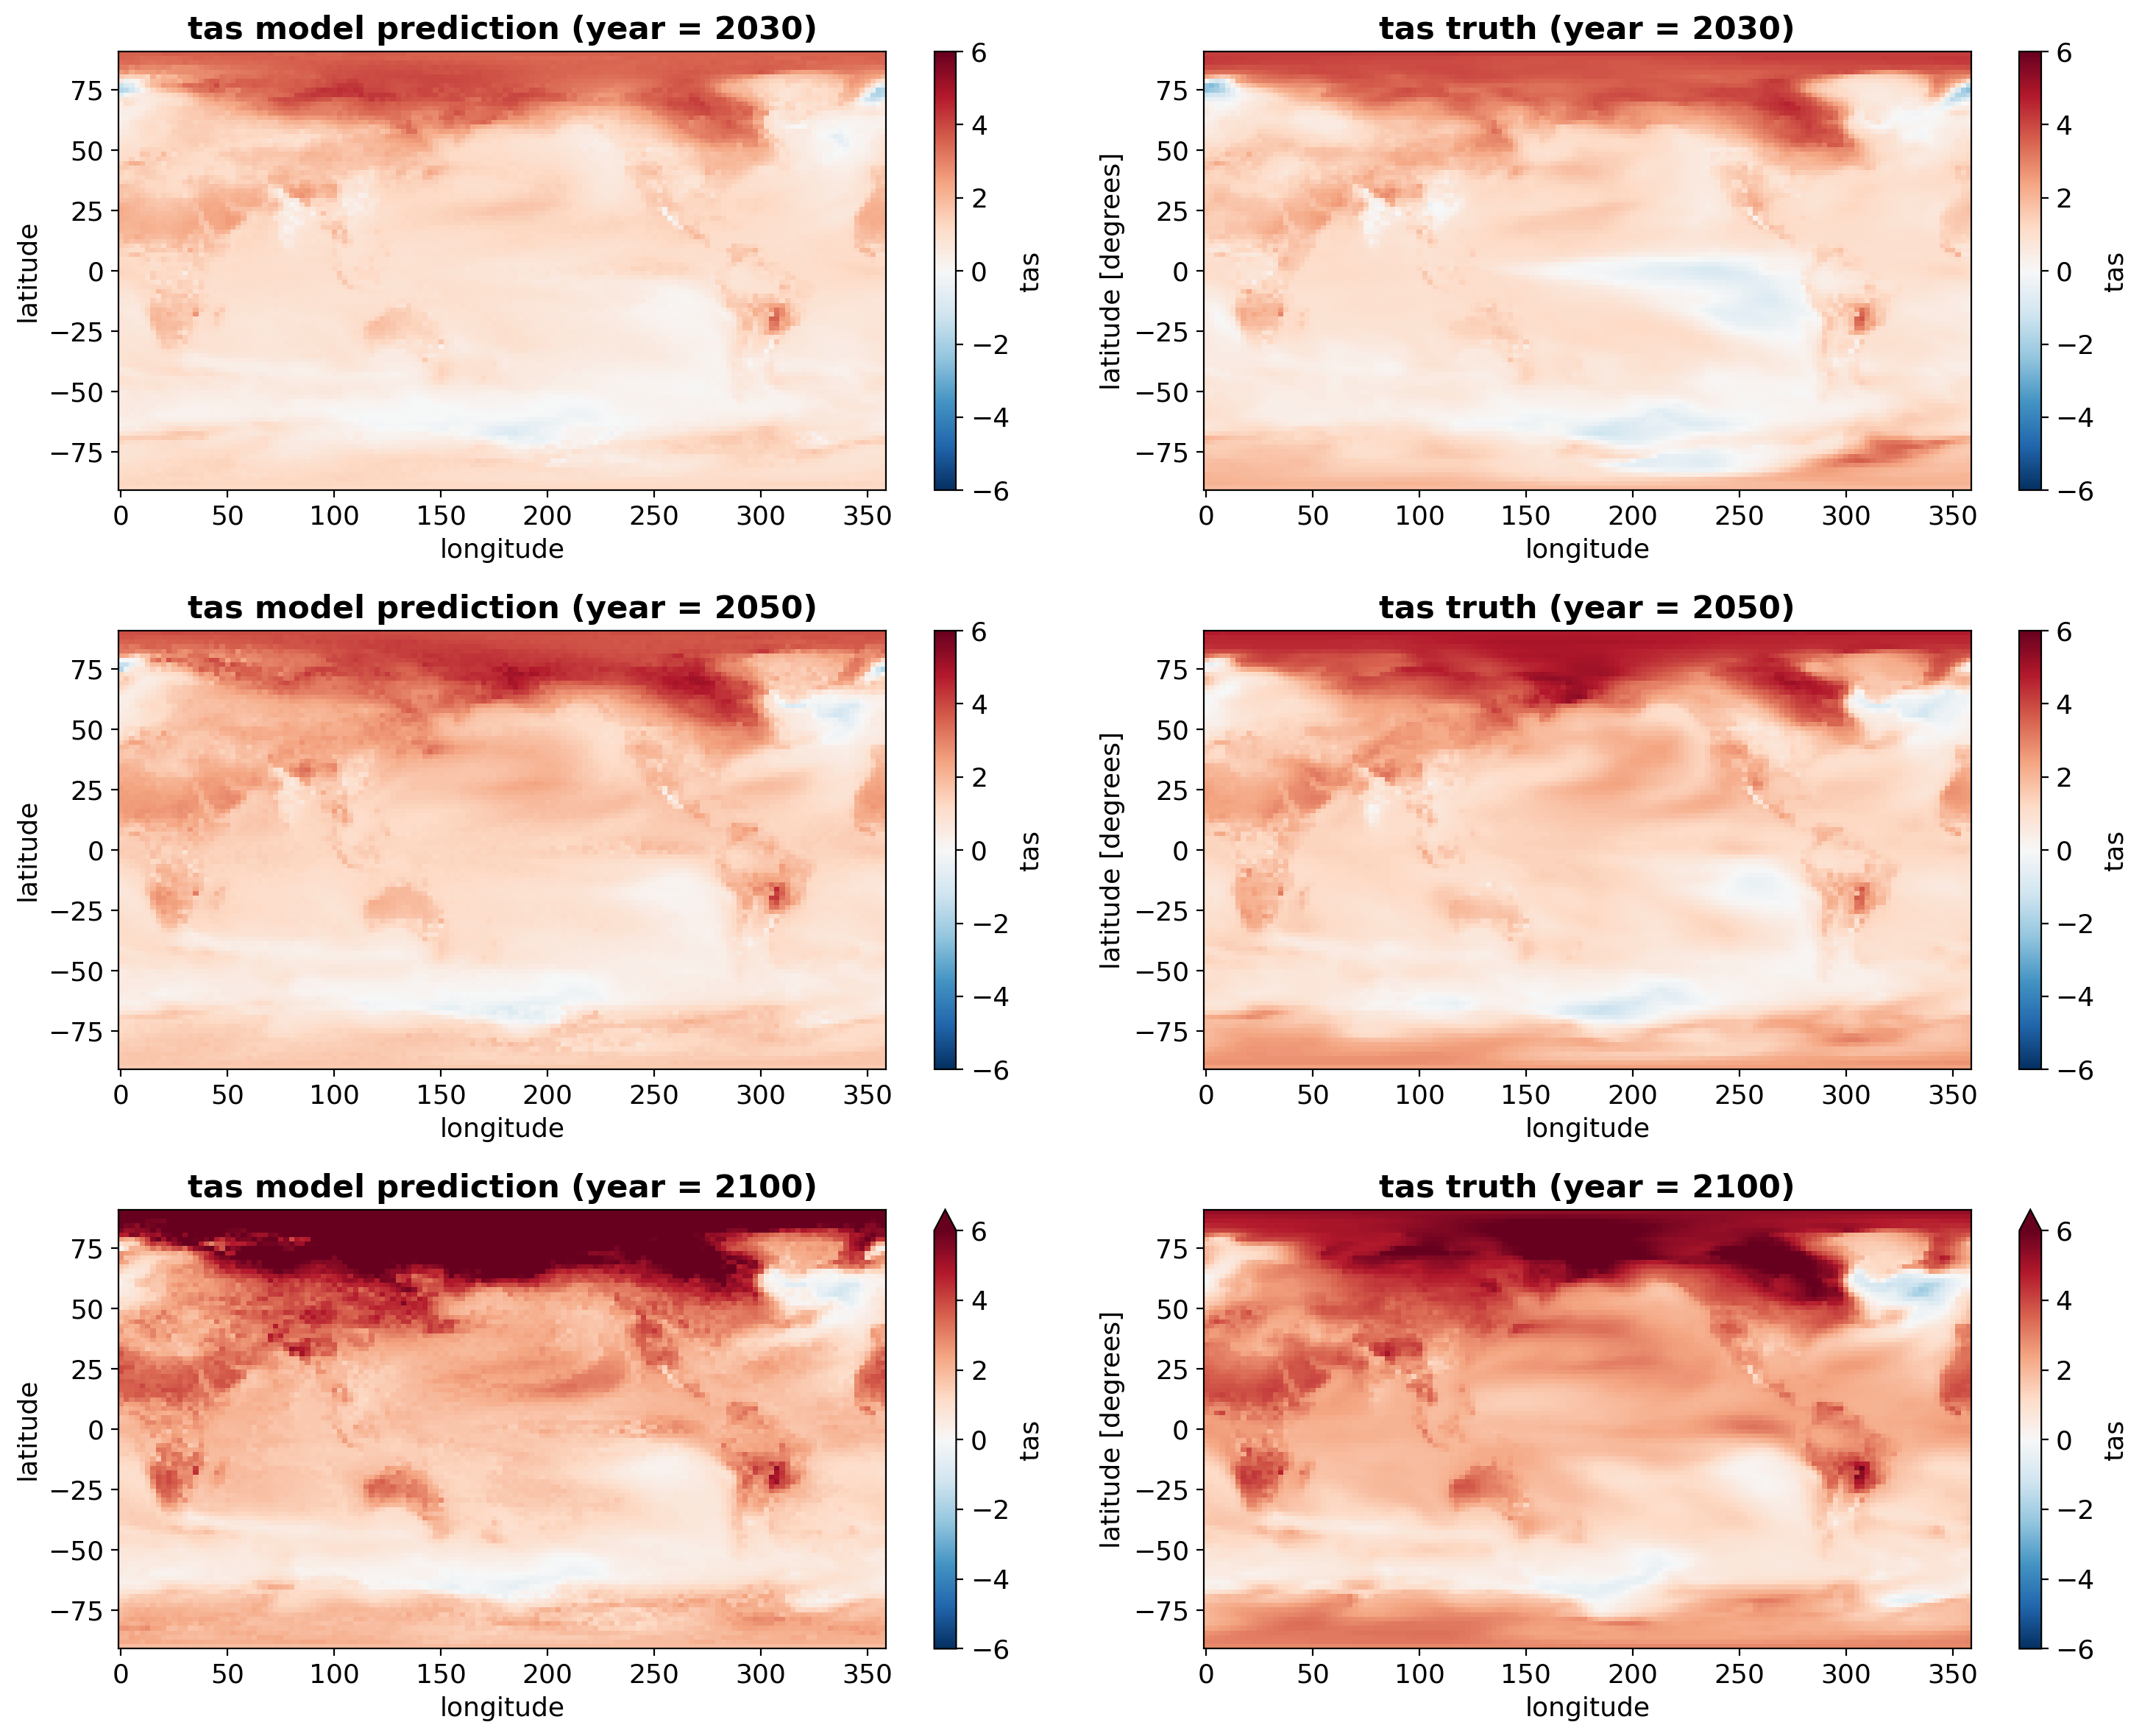

In [14]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pred1.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pred1.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pred1.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

#### Option 2: apply hyperparameter tuning to find the best parameter

One may also perform hyperparameter tuning by using hyperopt package. Reference: <a href="https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning">xgboost hyperparameter tuing</a>


In [29]:
# hyperparameters option list
n_estimators_list = [int(x) for x in np.linspace(start=20, stop=100, num=9)]
max_depth_list = [5, 10, 15, 20]
reg_alpha_list = [0.1, 0.2, 0.3]
reg_lambda_list = [0.7, 0.8, 0.9]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]
eta_list = [0.05, 0.1, 0.15, 0.2]
eval_metric_list = ['rmse','mae','mape','logloss']

# Initialize domain space for range of values 
space={'n_estimators': hp.choice('n_estimators', n_estimators_list),
       'max_depth': hp.choice("max_depth", max_depth_list),
       'gamma': hp.uniform ('gamma', 1, 9),
       'reg_alpha' : hp.choice('reg_alpha', reg_alpha_list),
       'reg_lambda' : hp.choice('reg_lambda', reg_lambda_list),
       'subsample' : hp.choice('subsample', subsample_list),
       'eta' : hp.choice('eta', eta_list),
       'eval_metric' : hp.choice('eval_metric', eval_metric_list),
       'tree_method' : 'hist',
       'seed': 5
    }


In [30]:
# define objective function
def objective(space):
    n_estimators = space['n_estimators']
    learning_rate = space['eta']
    gamma = space['gamma']
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    lamb = space['reg_lambda']
    alpha = space['reg_alpha']
    eval_metric = space['eval_metric']
    seed = space['seed']
    
    xgb_regressor = XGBRegressor(n_estimators = n_estimators,
                                 eta = learning_rate,
                                 gamma = gamma,
                                 max_depth = max_depth,
                                 subsample = subsample,
                                 reg_lambda = lamb,
                                 reg_alpha = alpha,
                                 tree_method = 'hist',
                                 eval_metric = eval_metric,
                                 seed = 5,
                                 verbosity = 1)

    
    multioutput_regressor = MultiOutputRegressor(xgb_regressor)
    multioutput_regressor.fit(X_train, y_train)
    
    y_test_pred = multioutput_regressor.predict(X_test)
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    print("loss (rmse): "+str(rmse))
    print("n_estimators = "+str(n_estimators)+"; eta = "+str(learning_rate)+"; gamma = "+str(gamma)+"; max_depth = "+str(max_depth))
    print("subsample = "+str(subsample)+"; reg_lambda = "+str(lamb)+"; reg_alpha = "+str(alpha)+"; eval_metric = "+str(eval_metric))
    print('----------------------------------------------------------------------------------------')
    return {'loss': rmse, 'status': STATUS_OK }

In [31]:
# find the best hyperparameters of 10 trials
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)


loss (rmse): 0.46103293                               
n_estimators = 60; eta = 0.15; gamma = 8.195430646156701; max_depth = 5
subsample = 0.7; reg_lambda = 0.8; reg_alpha = 0.1; eval_metric = mape
----------------------------------------------------------------------------------------
loss (rmse): 0.5215084                                                           
n_estimators = 40; eta = 0.05; gamma = 4.59655472557526; max_depth = 15          
subsample = 0.7; reg_lambda = 0.7; reg_alpha = 0.1; eval_metric = mae            
----------------------------------------------------------------------------------------
loss (rmse): 0.44949073                                                          
n_estimators = 100; eta = 0.1; gamma = 2.8563929677002013; max_depth = 10        
subsample = 0.6; reg_lambda = 0.7; reg_alpha = 0.2; eval_metric = rmse           
----------------------------------------------------------------------------------------
loss (rmse): 0.45883706                    

In [32]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams) # if hp.choice, the output is the position of the list
print("eta = ", eta_list[best_hyperparams['eta']]) # an example of find the exact value of the position


The best hyperparameters are :  

{'eta': 1, 'eval_metric': 0, 'gamma': 2.8563929677002013, 'max_depth': 1, 'n_estimators': 8, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0}
eta =  0.1


In [33]:
# build a regressor with the best hyperparameters
xgb_regressor2 = XGBRegressor(n_estimators = n_estimators_list[best_hyperparams['n_estimators']],
                              eta = eta_list[best_hyperparams['eta']],
                              gamma = best_hyperparams['gamma'],
                              max_depth = max_depth_list[best_hyperparams['max_depth']],
                              subsample = subsample_list[best_hyperparams['subsample']],
                              reg_lambda = reg_lambda_list[best_hyperparams['reg_lambda']],
                              reg_alpha = reg_alpha_list[best_hyperparams['reg_alpha']],
                              tree_method = 'hist',
                              eval_metric = eval_metric_list[best_hyperparams['eval_metric']],
                              seed = 5,
                              verbosity = 1)

multioutput_regressor2 = MultiOutputRegressor(xgb_regressor2)
multioutput_regressor2.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.1,
                                            eval_metric='rmse',
                                            feature_types=None,
                                            gamma=2.8563929677002013,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, ...))

Evaluate the model

In [34]:
# generate predictions
y_test_pred2 = multioutput_regressor2.predict(X_test)

# evaluate the predictions
mae2 = mean_absolute_error(y_test, y_test_pred2)
print(f"Mean Absolute Error: {mae2}")

rmse2 = mean_squared_error(y_test, y_test_pred2, squared=False)
print(f"Root Mean Squared Error: {rmse2}")


# reshape the prediction matrix as a global map
y_test_pred2 = y_test_pred2.reshape(y_test_pred2.shape[0], 96, 144)

y_test_pred2 = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                        data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pred2)))


Mean Absolute Error: 0.36342576146125793
Root Mean Squared Error: 0.4494907259941101


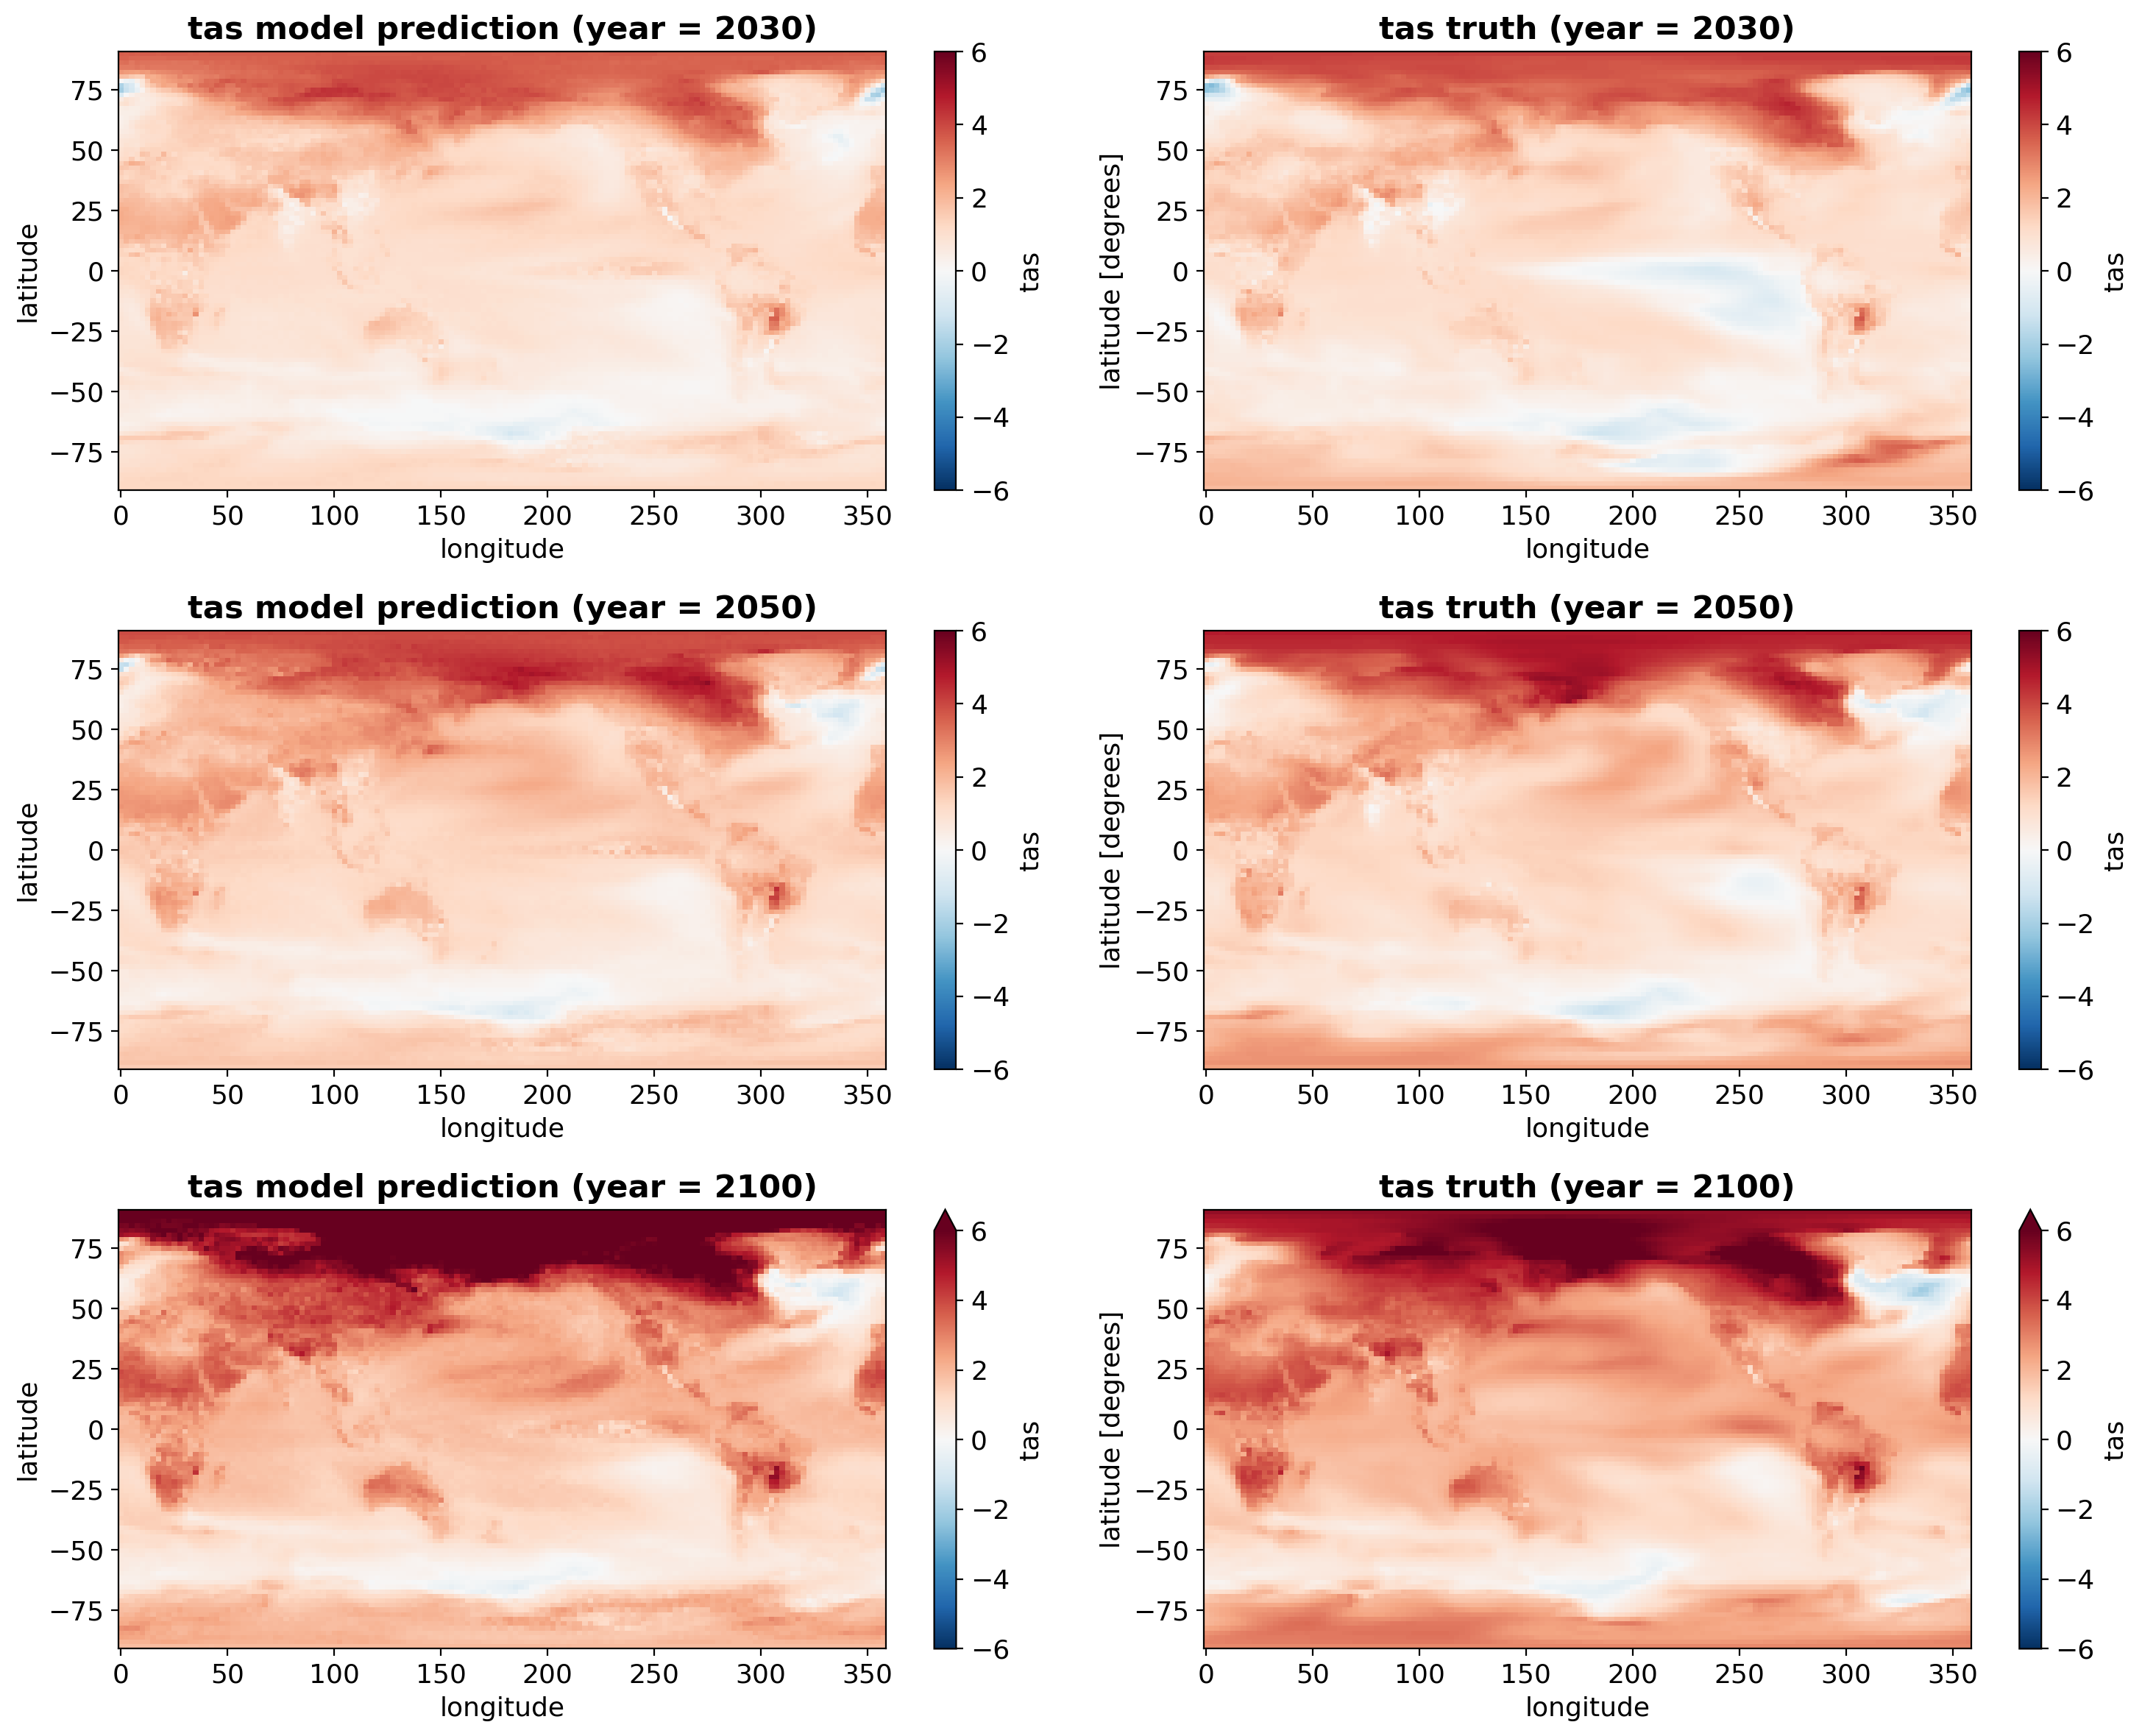

In [35]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pred2.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pred2.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pred2.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()


### 3. Get SHAP Values and Plots

Reference: <a href="https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Multioutput%20Regression%20SHAP.html">SHAP values</a>

In [37]:
# Set the explainer using the Kernel Explainer (Model agnostic explainer method form SHAP)
# if using xgboost without the wrapper from MultiOutputRegressor, use Tree-based SHAP
explainer = shap.KernelExplainer(model=multioutput_regressor2.predict, 
                                 data=X_test_df, 
                                 link="identity")


Get the SHAP value for a single year

In [38]:
# Set the index of the specific example to explain
X_idx = 0   # year 2015

# get the SHAP value for the single example
shap_value_single = explainer.shap_values(X=X_test_df.iloc[X_idx : X_idx + 1, :], nsamples=100)


  0%|          | 0/1 [00:00<?, ?it/s]

Get the SHAP value for all prediction years

In [39]:
# get SHAP values for all prediction years
# Noted that calculating SHAP value can be time consuming, 
# we can also take a small part of X (either training or testing) to do so.
shap_values = explainer.shap_values(X=X_test_df.iloc[:, :], nsamples=100)


  0%|          | 0/86 [00:00<?, ?it/s]

**Interactive plots:**
Choose the label/output/target to run individual explanations on (here we select a grid in global map)

In [40]:
# Create the list of all labels for the drop down list
list_of_labels = y_test_df.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(
    options=tuple_of_labels, value=0, description="Select Label:"
)

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label


Dropdown(description='Select Label:', options=(((-90.0, 0.0), 0), ((-90.0, 2.5), 1), ((-90.0, 5.0), 2), ((-90.…

the contribution of CO2 & CH4 to air temperature in a single year (here 2015) at the selected grid

In [44]:
# print the JS visualization code to the notebook
shap.initjs()

print(f"Current label Shown: {list_of_labels[current_label.value]}")

# check the force plot to see the contribution of CO2 & CH4 to air temperature 
# at the selected grid at year 2015
shap.force_plot(
    base_value=explainer.expected_value[current_label.value],
    shap_values=shap_value_single[current_label.value],
    features=X_test_df.iloc[X_idx : X_idx + 1, :],
)


Current label Shown: (-55.89473684210527, 272.5)


the contribution of CO2 & CH4 to air temperature in all prediction years (2015-2100) at the selected grid

Current Label Shown: (-55.89473684210527, 272.5)



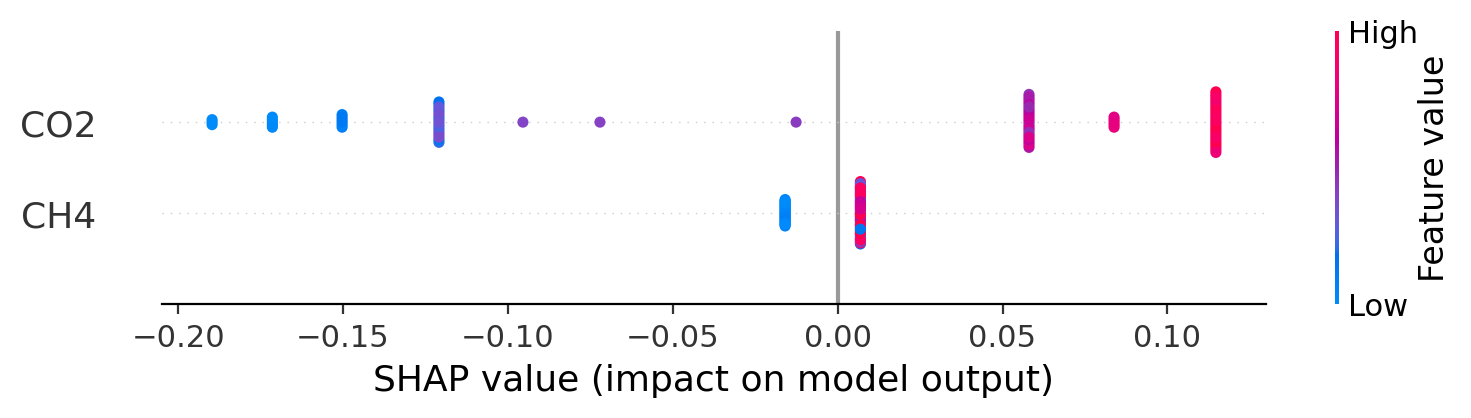

In [45]:
print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

shap.summary_plot(
    shap_values=shap_values[current_label.value], features=X_test_df.iloc[:, :]
)


the contribution of CO2 & CH4 to air temperature along the time series (2015-2100) at the selected grid

In [46]:
print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

# print the JS visualization code to the notebook
shap.initjs()

shap.force_plot(
    base_value=explainer.expected_value[current_label.value],
    shap_values=shap_values[current_label.value],
    features=X_test_df.iloc[:, :]
)


Current Label Shown: (-55.89473684210527, 272.5)

